# Mimicking Keras using PyOpenCL for convolutions etc

Same goal as mimic_keras_predict but this time we're going to try to push convolution and pooling onto a GPU/FPGA using PyOpenCL.

In [1]:
#System imports
from __future__ import print_function

#External imports 
from keras import models, layers
from keras import backend as K
from matplotlib import pyplot as plt

#Local imports 
from naive_prediction.data_utils import read_keras_model_from_file
#from forward_pass import predict_with_keras_model
from data import generate_straight_tracks
from drawing import draw_2d_event, draw_2d_input_and_pred
#import tests

#For consistent printing
import numpy as np
import pyopencl as cl
from pyopencl import array
np.set_printoptions(suppress=True)

#to test performance
import time

#for colors
from termcolor import colored

%load_ext autoreload
%autoreload 2
%matplotlib notebook

#pyopencl magic
%load_ext pyopencl.ipython_ext

Using TensorFlow backend.


## Now we load our trained model and see how Keras predicts with it

In [3]:
#load model, summary
model = read_keras_model_from_file('/home/boser/opencl-cnn/model1.h5')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 64, 64)        0                                            
____________________________________________________________________________________________________
reshape_5 (Reshape)              (None, 64, 64, 1)     0           input_3[0][0]                    
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 64, 8)     80          reshape_5[0][0]                  
____________________________________________________________________________________________________
convolution2d_28 (Convolution2D) (None, 64, 64, 8)     584         convolution2d_27[0][0]           
___________________________________________________________________________________________

In [4]:
# Batch generator function, from heptrkx
def batch_generator_convae(num_event, det_shape, num_tracks, binary=True):
    """
    Generator function for batches of toy data for training.
    This function generates a fixed number of tracks in a batch.
    """
    while True:
        events = sum(generate_straight_tracks(num_event, det_shape)
                     for i in range(num_tracks))
        if binary:
            events[events > 1] = 1
        # Input and target are the same here
        yield events, events

<IPython.core.display.Javascript object>


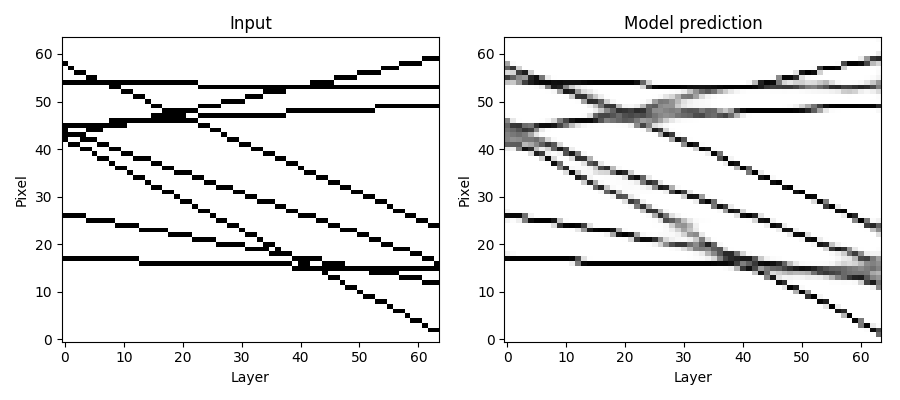

In [5]:
num_test = 1
det_shape = (64, 64)
num_tracks = 8
test_events, test_target = batch_generator_convae(num_test, det_shape, num_tracks).next()
test_pred = model.predict(test_events)
draw_2d_input_and_pred(test_events[0], test_pred[0], cmap='gray_r');

## The prediction looks good
## Now let's set up PyOpenCL!
We're going to be running everything on a GPU now.

In [6]:
platforms = cl.get_platforms()
print(platforms)

[<pyopencl.Platform 'NVIDIA CUDA' at 0x56279df0c190>]


In [7]:
devices = platforms[0].get_devices()
print(devices)

[<pyopencl.Device 'GeForce GTX 980 Ti' on 'NVIDIA CUDA' at 0x56279df19a00>]


In [8]:
#I'll use my CPU for this example.
ctx = cl.Context([devices[0]])
queue = cl.CommandQueue(ctx)

### We need to create Kernels which can be run on GPUs/FPGAs
Overall very similar to C code, these kernels allow our code to be parallelized. I've created 3 kernels for various activation functions in order to minimize number of conditionals. The kernel code currently contains only the convolution operation and none of the preparation (i.e padding). Will need to look into whether it makes sense to push the preparation onto an FPGA as well.

In [9]:
%%cl_kernel -o "-cl-fast-relaxed-math"

__kernel void convolute_2d(__global float *c,
__global const float *a, __global float *b, __constant float *d, int filter_size,
int output_width_height, int num_filters, int num_input_channels, int padded_matrix_dim)
{
    size_t j = get_global_id(0); //height
    size_t i = get_global_id(1); //width
    size_t k = get_global_id(2); //num filters (output depth)
    size_t h;
    size_t l;
    size_t s;
    float conv_result = 0;
    for(h = 0; h < num_input_channels; h++) {
        for(l = 0; l < filter_size; l++) {
            if(num_input_channels == 1) {
                for(s = 0; s < filter_size; s++) {
                    conv_result += b[k + s*num_filters + l*num_filters*filter_size]*a[j+s + (i+l)*padded_matrix_dim];
                }
            } else {
                for(s = 0; s < filter_size; s++) {
                    conv_result += b[k + h*num_filters + s*num_filters*num_input_channels + l*num_filters*num_input_channels*filter_size]*a[h + (j+s)*num_input_channels + (i+l)*num_input_channels*padded_matrix_dim];
                }
            }
        }
    }
    conv_result += d[k];
    c[k + j*num_filters + i*num_filters*output_width_height] = conv_result;
}

In [10]:
%%cl_kernel -o "-cl-fast-relaxed-math"

__kernel void convolute_2d_relu(__global float *c,
__global const float *a, __global float *b, __constant float *d, int filter_size,
int output_width_height, int num_filters, int num_input_channels, int padded_matrix_dim)
{
    size_t j = get_global_id(0); //height
    size_t i = get_global_id(1); //width
    size_t k = get_global_id(2); //num filters (output depth)
    size_t h;
    size_t l;
    size_t s;
    float conv_result = 0;
    for(h = 0; h < num_input_channels; h++) {
        for(l = 0; l < filter_size; l++) {
            if(num_input_channels == 1) {
                for(s = 0; s < filter_size; s++) {
                    conv_result += b[k + s*num_filters + l*num_filters*filter_size]*a[j+s + (i+l)*padded_matrix_dim];
                }
            } else {
                for(s = 0; s < filter_size; s++) {
                    conv_result += b[k + h*num_filters + s*num_filters*num_input_channels + l*num_filters*num_input_channels*filter_size]*a[h + (j+s)*num_input_channels + (i+l)*num_input_channels*padded_matrix_dim];
                }
            }
        }
    }
    conv_result += d[k];
    if (conv_result < 0) {
        conv_result = 0;
    }
    c[k + j*num_filters + i*num_filters*output_width_height] = conv_result;
}

In [11]:
%%cl_kernel -o "-cl-fast-relaxed-math"

__kernel void convolute_2d_sigmoidal(__global float *c,
__global const float *a, __global float *b, __constant float *d, int filter_size,
int output_width_height, int num_filters, int num_input_channels, int padded_matrix_dim)
{
    size_t j = get_global_id(0); //height
    size_t i = get_global_id(1); //width
    size_t k = get_global_id(2); //num filters (output depth)
    size_t h;
    size_t l;
    size_t s;
    float conv_result = 0;
    for(h = 0; h < num_input_channels; h++) {
        for(l = 0; l < filter_size; l++) {
            if(num_input_channels == 1) {
                for(s = 0; s < filter_size; s++) {
                    conv_result += b[k + s*num_filters + l*num_filters*filter_size]*a[j+s + (i+l)*padded_matrix_dim];
                }
            } else {
                for(s = 0; s < filter_size; s++) {
                    conv_result += b[k + h*num_filters + s*num_filters*num_input_channels + l*num_filters*num_input_channels*filter_size]*a[h + (j+s)*num_input_channels + (i+l)*num_input_channels*padded_matrix_dim];
                }
            }
        }
    }
    conv_result += d[k];
    //S(x) = 1 / 1 + e^-x
    conv_result = 1 / (1 + exp(-conv_result));
    c[k + j*num_filters + i*num_filters*output_width_height] = conv_result;
}

### Wrapping code for convolution
Padding, turns ndarrays into arrays that can be used in openCL

In [12]:
def zero_pad_matrix(input_matrix, num_zeros):
    """
    Pad the 3d (nxmxz) input matrix with p zeros
    Assumes 'reshaped' matrix. Need to look at this more closely.
    """
    num_zeros = int(num_zeros)
    return np.pad(input_matrix, ((0, 0), (num_zeros, num_zeros),
                                 (num_zeros, num_zeros), (0, 0)), 'constant')

def keras_single_layer_output(model, layer_number, tinput):
    """
    To test other functions
    """
    get_layer_output = K.function([model.layers[layer_number-1].input],
                                   [model.layers[layer_number].output])
    return get_layer_output([tinput][0])


def convolution_2d(input_matrix, filter_weights, stride, activation='relu', padding='same'):
    weights_matrix = filter_weights[0]
    bias_vector = filter_weights[1]

    #pad matrix to maintain input dimensions
    filter_dim = len(weights_matrix)
    if padding == 'same':
        num_zeros_padding = (filter_dim - 1) / 2
        padded_matrix = zero_pad_matrix(input_matrix, num_zeros_padding)
    else:
        padded_matrix = input_matrix
        
    padded_matrix_dim = len(padded_matrix[0][0])
    num_filters = len(weights_matrix.T)

    try:
        num_input_channels = len(input_matrix[0][0][0])
    except:
        num_input_channels = 1
    output_matrix_width_height = padded_matrix_dim - filter_dim + 1
    
    a = cl.array.to_device(queue, padded_matrix)
    b = cl.array.to_device(queue, weights_matrix)
    c = cl.array.zeros(queue, shape=(1, output_matrix_width_height,
                                     output_matrix_width_height, num_filters),
                      dtype=np.float32)
    d = cl.array.to_device(queue, bias_vector)
    
    if activation=='relu':
        convolute_2d_relu(queue, (output_matrix_width_height, 
                             output_matrix_width_height,
                             num_filters,), None, c.data, a.data, b.data, d.data, np.int32(filter_dim),
                    np.int32(output_matrix_width_height), np.int32(num_filters), np.int32(num_input_channels),
                    np.int32(padded_matrix_dim))
    elif activation=='sigmoid':
        convolute_2d_sigmoidal(queue, (output_matrix_width_height, 
                             output_matrix_width_height,
                             num_filters,), None, c.data, a.data, b.data, d.data, np.int32(filter_dim),
                    np.int32(output_matrix_width_height), np.int32(num_filters), np.int32(num_input_channels),
                    np.int32(padded_matrix_dim))
    else:
        convolute_2d(queue, (output_matrix_width_height, 
                             output_matrix_width_height,
                             num_filters,), None, c.data, a.data, b.data, d.data, np.int32(filter_dim),
                    np.int32(output_matrix_width_height), np.int32(num_filters), np.int32(num_input_channels),
                    np.int32(padded_matrix_dim))
    
    return c.get()

Looks good. Now let's test this convolution operation against Keras and make sure we're getting the same result!

In [13]:
def keras_get_layer_output(model, layer, test_input):
    """
    Helper method, gives the output matrix from a Keras layer
    """
    get_layer_output = K.function([model.layers[0].input],
                                  [layer.output])
    return get_layer_output([test_input])[0]

In [14]:
input_layer = model.layers[1]
output_layer = model.layers[2]
test_input_matrix = keras_get_layer_output(model, input_layer, test_events)
test_correct_output = keras_get_layer_output(model, output_layer, test_events)

In [15]:
our_test_output = convolution_2d(test_input_matrix, output_layer.get_weights(), 1, activation='relu')

In [16]:
def compare_ndarrays(keras_ndarray, comparison_ndarray):
    """
    Returns total difference between two ndarrays.
    """
    if keras_ndarray.shape != comparison_ndarray.shape:
        print("Unable to compare ndarrays with different shape.")
        print("Keras ndarray shape:", keras_ndarray.shape)
        print("Your ndarray shape:", comparison_ndarray.shape)
        return -1

    if np.array_equal(keras_ndarray, comparison_ndarray):
        print("Keras ndarray and comparison ndarray are the same.")
        return 0
    
    if np.allclose(keras_ndarray, comparison_ndarray, atol=0.001):
        print("Every item in Keras ndarray and comparison ndarray within 0.001 of eachother.")
    print("Keras ndarray and comparison ndarray are NOT the same.")
    print("A total of", np.sum(keras_ndarray == comparison_ndarray)," out of",
                               keras_ndarray.size ," elements are the same.")
    return abs(np.sum(keras_ndarray - comparison_ndarray))

In [17]:
compare_ndarrays(test_correct_output, our_test_output)

Keras ndarray and comparison ndarray are the same.


0

Perfect, we're getting an exact match! Looks like our convolution operation is perfect!

### Max pooling
Well convolution works, now let's try and do the same for max pooling. Should be straightforward. 

In [18]:
%%cl_kernel -o "-cl-fast-relaxed-math"

__kernel void max_pool_2d(__global float *c,
__global const float *a, int kernel_size, int stride,
int output_width_height, int num_filters, int input_w_h)
{
    size_t j = get_global_id(0); //height
    size_t i = get_global_id(1); //width
    size_t k = get_global_id(2); //num filters (output depth)
    int l;
    int s;
    int i_i = i*2;
    int j_j = j*2;
    float curr_max = 0;
    for (l = 0; l < kernel_size; l++) {
        for (s = 0; s < kernel_size; s++) {
            if (curr_max < a[k + (j_j+s)*num_filters + (i_i+l)*num_filters*input_w_h]) {
                curr_max = a[k + (j_j+s)*num_filters + (i_i+l)*num_filters*input_w_h];
            }
        }
    } 

    c[k + j*num_filters + i*num_filters*output_width_height] = curr_max;
}

In [19]:
def maxpooling_2d(input_matrix, kernel_size, stride):
    input_matrix_width_height = len(input_matrix[0])
    input_matrix_depth = len(input_matrix[0][0][0])
    output_matrix_width_height = int(((input_matrix_width_height - kernel_size) / stride) + 1)

    c = cl.array.zeros(queue, shape=(1, output_matrix_width_height,
                                     output_matrix_width_height, input_matrix_depth),
                      dtype=np.float32)
    a = cl.array.to_device(queue, input_matrix)
    
    max_pool_2d(queue, (output_matrix_width_height, 
                         output_matrix_width_height,
                         input_matrix_depth,), None, c.data, a.data, np.int32(kernel_size),
                np.int32(stride), np.int32(output_matrix_width_height), np.int32(input_matrix_depth),
                np.int32(input_matrix_width_height))
    
    return c.get()

In [20]:
input_layer_pool = model.layers[3]
output_layer_pool = model.layers[4]
test_input_matrix_pool = keras_get_layer_output(model, input_layer_pool, test_events)
test_correct_output_pool = keras_get_layer_output(model, output_layer_pool, test_events)

In [21]:
our_test_output_pool = maxpooling_2d(test_input_matrix_pool, 2, 2)

In [22]:
#now we check to make sure pooling works consistently with keras' pooling
compare_ndarrays(test_correct_output_pool, our_test_output_pool)

Keras ndarray and comparison ndarray are the same.


0

Great! Max pooling works using our parallelized opencl kernel.
### Upsampling, reshaping arrays
Does it make sense to upsample on the FPGA? Maybe not for now, values are simply being mapped to one another (assigning one value in the input array to multiple in the output array). Numpy will probably do this more efficiently on a CPU than we will on an FPGA. Will want to look into this however.

Sample applies to reshape.

In [23]:
def upsampling_2d(input_matrix, kernel_size):
    """
    Increase width and height of input matrix.
    """
    output_matrix = np.repeat(np.repeat(input_matrix, kernel_size, axis=1), kernel_size, axis=2)
    return output_matrix


In [24]:
def reshape(inputs, target_shape):
    return np.reshape(inputs, (-1,) + target_shape)

#def reshape_tf(inputs, target_shape):
#    return tf.reshape(inputs, (1,) + target_shape).eval()

#def reshape_keras(inputs, target_shape):
#    return K.reshape(inputs, (1,) + target_shape)

print(reshape(test_events, (64, 64, 1)).shape)
#print(reshape_tf(test_events, (64, 64, 1)))
#print(reshape_keras(test_events, (64, 64, 1)))
print(test_input_matrix.shape)
print(np.array_equal(test_input_matrix, reshape(test_events, (64, 64, 1))))

(1, 64, 64, 1)
(1, 64, 64, 1)
True


### Making a full prediction using parallelized convolution and pooling
Let's time it to see how we compare to Keras! This is still all being done on a CPU.

In [25]:
def get_layer_type(keras_layer):
    """
    return string describing the type of a layer
    """
    config = keras_layer.get_config()
    return config['name'].split('_', 1)[0]

def predict_with_keras_model(keras_model, event):
    prediction = event
    for layer in keras_model.layers:

        #get layer information via keras
        layer_type = get_layer_type(layer)
        layer_config = layer.get_config()

        #perform appropriate operation
        if layer_type == 'convolution2d':
            prediction = convolution_2d(prediction, layer.get_weights(), 1, activation=layer_config['activation'], padding='same')
        if layer_type == 'maxpooling2d':
            prediction = maxpooling_2d(prediction, layer_config['pool_size'][0], layer_config['strides'][0])
        #not parallelized
        if layer_type == 'reshape':
            if(layer_config['target_shape'] != (64, 64, 1)):
                prediction = reshape(prediction, layer_config['target_shape'])
        if layer_type == 'upsampling2d':
            prediction = upsampling_2d(prediction, layer_config['size'][0])
    return prediction

In [26]:
start = time.time()
our_prediction = predict_with_keras_model(model, test_input_matrix)
end = time.time()
print("A single prediction took", end-start, " seconds.")

A single prediction took 0.0469059944153  seconds.


Our prediction


<IPython.core.display.Javascript object>


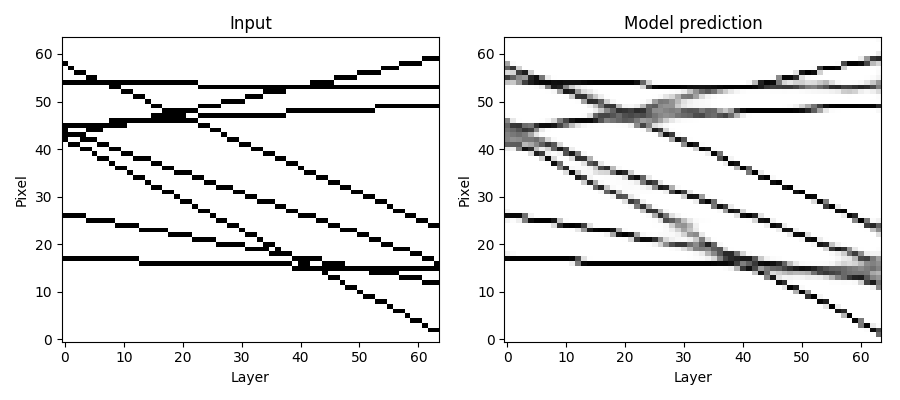

Keras prediction


<IPython.core.display.Javascript object>


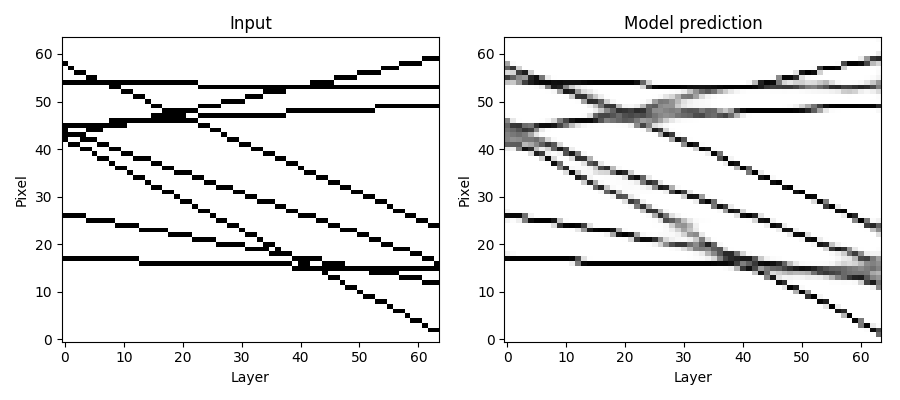

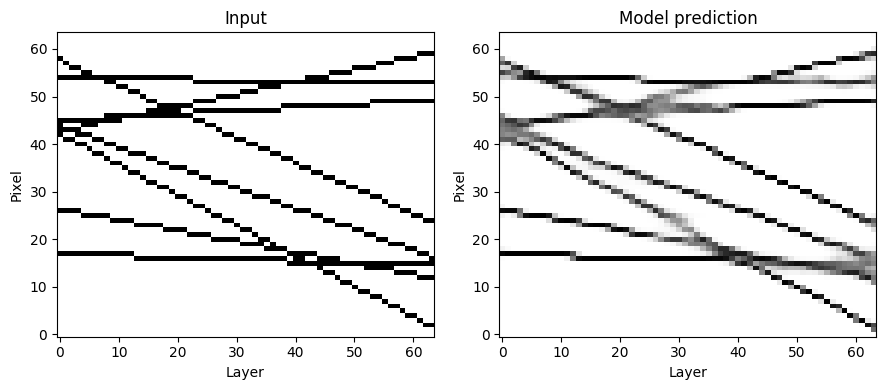

In [27]:
print("Our prediction")
draw_2d_input_and_pred(test_events[0], our_prediction[0], cmap='gray_r');
print("Keras prediction")
draw_2d_input_and_pred(test_events[0], test_pred[0], cmap='gray_r')

There was some issue with numpy's reshape module so I've been forced to use Keras' reshaped input. 
Oh well, aside from that it works! Now we've just got to run this on an FPGA!

In [28]:
def full_run_comparison(keras_model, test_input, cheaters_input):
    """
    From start to finish compare the output of a Keras prediction to
    a prediction done using forward_pass.py
    """
    previous_layer_output_keras = test_input
    previous_layer_output_self = cheaters_input

    for layer in keras_model.layers:

        #get layer information via keras
        layer_type = get_layer_type(layer)
        layer_config = layer.get_config()

        #perform appropriate operation
        if layer_type == 'convolution2d':
            previous_layer_output_self = convolution_2d(previous_layer_output_self, layer.get_weights(), 1, activation=layer_config['activation'], padding='same')
            self_out_with_keras_input = convolution_2d(previous_layer_output_keras, layer.get_weights(), 1, activation=layer_config['activation'], padding='same')
        elif layer_type == 'maxpooling2d':
            previous_layer_output_self = maxpooling_2d(previous_layer_output_self, layer_config['pool_size'][0], layer_config['strides'][0])
            self_out_with_keras_input = maxpooling_2d(previous_layer_output_keras, layer_config['pool_size'][0], layer_config['strides'][0])
        elif layer_type == 'reshape':
            if layer_config['target_shape'] != (64, 64, 1):
                previous_layer_output_self = reshape(previous_layer_output_self, layer_config['target_shape'])
                self_out_with_keras_input = reshape(previous_layer_output_keras, layer_config['target_shape'])
            else:
                self_out_with_keras_input = previous_layer_output_self
        elif layer_type == 'upsampling2d':
            previous_layer_output_self = upsampling_2d(previous_layer_output_self, layer_config['size'][0])
            self_out_with_keras_input = upsampling_2d(previous_layer_output_keras, layer_config['size'][0])
        else:
            continue

        #perform keras prediction for this layer
        previous_layer_output_keras = keras_get_layer_output(keras_model, layer, test_input)

        #now let's see how we compare to keras
        print("\n===========================================================================")
        print("Forward pass on a", layer_config['name'],"layer.")
        if np.array_equal(self_out_with_keras_input, previous_layer_output_keras):
            print(colored("PASS: This layer successfully produces the same results as Keras.", 'green'))
        else:
            print(colored("FAIL: This layer does no perform in the same way as Keras.", 'red'))
        if previous_layer_output_keras.shape != self_out_with_keras_input.shape:
            print(colored("CRITICAL ERROR: This layer returns the wrong output shape.", 'red'))
        print("Using self output as input", np.sum(previous_layer_output_self == previous_layer_output_keras),
                                                   " of", previous_layer_output_keras.size, " correctly predicted")
        print("Using keras output as input", np.sum(self_out_with_keras_input == previous_layer_output_keras),
                                                    " of", previous_layer_output_keras.size, " correctly predicted")
        if np.allclose(previous_layer_output_self, previous_layer_output_keras, atol=0.001):
            print(colored("SUCCESS: All output values within 0.001 of eachother.", 'green'))
        else:
            print(colored("FAIL: All output values NOT within 0.001 of eachother.", 'red'))
        print("===========================================================================")
    return previous_layer_output_self, previous_layer_output_keras

In [29]:
#This function tells us layer by layer how our layers are performing in comparison to Keras'.
ourout, kerasout = full_run_comparison(model, test_events, test_input_matrix)


Forward pass on a reshape_5 layer.
PASS: This layer successfully produces the same results as Keras.
Using self output as input 4096  of 4096  correctly predicted
Using keras output as input 4096  of 4096  correctly predicted
SUCCESS: All output values within 0.001 of eachother.

Forward pass on a convolution2d_27 layer.
PASS: This layer successfully produces the same results as Keras.
Using self output as input 32768  of 32768  correctly predicted
Using keras output as input 32768  of 32768  correctly predicted
SUCCESS: All output values within 0.001 of eachother.

Forward pass on a convolution2d_28 layer.
FAIL: This layer does no perform in the same way as Keras.
Using self output as input 27808  of 32768  correctly predicted
Using keras output as input 27808  of 32768  correctly predicted
SUCCESS: All output values within 0.001 of eachother.

Forward pass on a maxpooling2d_7 layer.
PASS: This layer successfully produces the same results as Keras.
Using self output as input 6300  of

Keras prediction vs our prediction


<IPython.core.display.Javascript object>


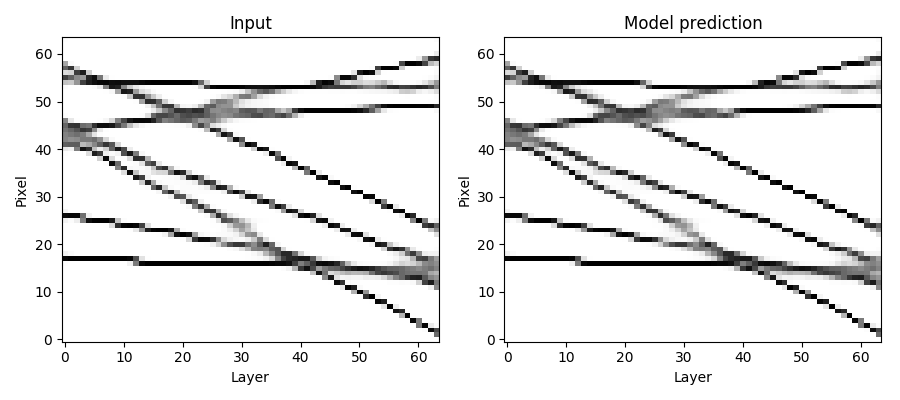

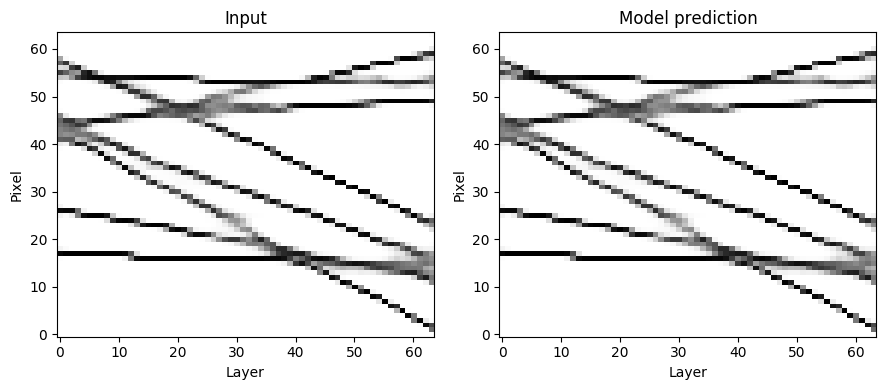

In [30]:
print("Keras prediction vs our prediction")
draw_2d_input_and_pred(kerasout[0], ourout[0], cmap='gray_r')